In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]
graph.add_edges(graph.edges()[1], graph.edges()[0])

In [4]:
MODEL_NB_NUMBER = 55
output_emb_file = f'../../models/graphsage_link_pred/full_graphsage_linkpred_{MODEL_NB_NUMBER}_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fe13045f660> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(89594)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

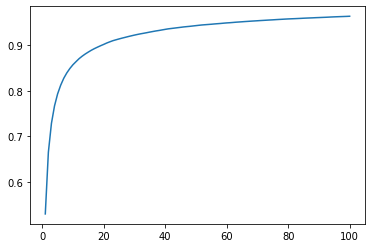

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.5291, 0.6646, 0.7282, 0.7666, 0.7929, 0.8121, 0.8273, 0.8392, 0.8490,
        0.8572, 0.8640, 0.8706, 0.8760, 0.8808, 0.8851, 0.8891, 0.8927, 0.8959,
        0.8990, 0.9019, 0.9050, 0.9076, 0.9101, 0.9120, 0.9139, 0.9157, 0.9174,
        0.9192, 0.9208, 0.9223, 0.9238, 0.9252, 0.9264, 0.9276, 0.9290, 0.9303,
        0.9315, 0.9325, 0.9338, 0.9350, 0.9361, 0.9369, 0.9377, 0.9386, 0.9394,
        0.9403, 0.9410, 0.9416, 0.9424, 0.9432, 0.9439, 0.9447, 0.9452, 0.9457,
        0.9462, 0.9469, 0.9474, 0.9479, 0.9486, 0.9492, 0.9496, 0.9501, 0.9507,
        0.9512, 0.9517, 0.9522, 0.9526, 0.9531, 0.9535, 0.9539, 0.9544, 0.9547,
        0.9552, 0.9556, 0.9559, 0.9564, 0.9568, 0.9571, 0.9575, 0.9579, 0.9582,
        0.9585, 0.9588, 0.9591, 0.9595, 0.9598, 0.9601, 0.9603, 0.9607, 0.9609,
        0.9612, 0.9615, 0.9618, 0.9622, 0.9625, 0.9627, 0.9630, 0.9632, 0.9635,
        0.9638])

In [18]:
percentages.max()

tensor(0.9638)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.67823884, 0.66426129, 0.65500788, 0.64776519, 0.64124056,
       0.63560053, 0.63082957, 0.62663721, 0.62265212, 0.61928748,
       0.61623397, 0.61336164, 0.61088533, 0.60836375, 0.60618311,
       0.60416211, 0.60219304, 0.60031448, 0.59861937, 0.59702586,
       0.59553181, 0.59413761, 0.59283256, 0.59154497, 0.5903011 ,
       0.58910136, 0.5879789 , 0.58687124, 0.58581736, 0.58481425,
       0.58386786, 0.58293836, 0.58202887, 0.5811998 , 0.58029798,
       0.57942624, 0.5786685 , 0.57788304, 0.57714058, 0.57634239,
       0.57559495, 0.57488872, 0.57417964, 0.57352412, 0.57289472,
       0.57226676, 0.57163926, 0.57101809, 0.57039818, 0.56979905,
       0.56923036, 0.56863823, 0.56811781, 0.56756843, 0.56704762,
       0.5665432 , 0.56605699, 0.56553186, 0.56505756, 0.56457092,
       0.56408262, 0.5636093 , 0.5631528 , 0.56271563, 0.56229183,
       0.56188739, 0.56146251, 0.56104822, 0.56063489, 0.56024299,
       0.55982645, 0.55943419, 0.55903496, 0.55863487, 0.55824

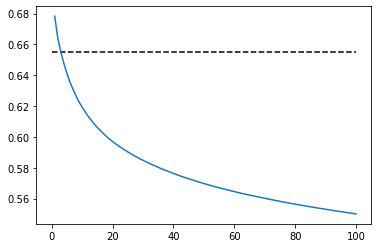

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fe003936a50> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(95614)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.9155236267288274

In [37]:
max_k = 1000
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  10839,  75036, ...,  75652, 128241, 156658],
       [     1, 154949, 100594, ...,   7748,  99482,  90921],
       [     2,  14632, 123185, ...,  22158,  60343,  18687],
       ...,
       [169340,   2618, 121241, ...,  99908,  85114, 155611],
       [169341,  80659, 123736, ..., 154689, 122113, 160869],
       [169342, 127946,  17652, ...,  39013,  25380,  17568]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.8310472534576547

In [40]:
distances

array([[0.9999998 , 0.9931267 , 0.9905644 , ..., 0.8904488 , 0.89006066,
        0.89003354],
       [0.9999999 , 0.99984014, 0.9553702 , ..., 0.485363  , 0.48514032,
        0.48506373],
       [1.        , 0.9847399 , 0.982689  , ..., 0.79700047, 0.7969087 ,
        0.7965322 ],
       ...,
       [1.0000001 , 0.97254235, 0.9640805 , ..., 0.7105947 , 0.71047974,
        0.71047175],
       [0.9999999 , 0.9819777 , 0.97867405, ..., 0.84955096, 0.8494043 ,
        0.84907347],
       [1.0000002 , 0.9564017 , 0.9051806 , ..., 0.5770676 , 0.5770606 ,
        0.5768973 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

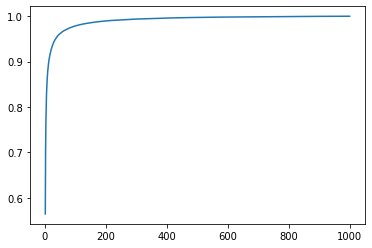

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.5646, 0.7038, 0.7669, 0.8039, 0.8283, 0.8459, 0.8592, 0.8698, 0.8783,
        0.8858, 0.8921, 0.8978, 0.9026, 0.9067, 0.9105, 0.9140, 0.9172, 0.9203,
        0.9232, 0.9257, 0.9280, 0.9301, 0.9324, 0.9344, 0.9361, 0.9379, 0.9397,
        0.9412, 0.9427, 0.9442, 0.9457, 0.9469, 0.9480, 0.9489, 0.9500, 0.9510,
        0.9519, 0.9530, 0.9541, 0.9550, 0.9558, 0.9567, 0.9574, 0.9582, 0.9589,
        0.9594, 0.9600, 0.9606, 0.9612, 0.9618, 0.9622, 0.9627, 0.9633, 0.9639,
        0.9645, 0.9651, 0.9656, 0.9659, 0.9664, 0.9669, 0.9673, 0.9677, 0.9680,
        0.9684, 0.9687, 0.9691, 0.9695, 0.9698, 0.9702, 0.9706, 0.9710, 0.9713,
        0.9716, 0.9719, 0.9722, 0.9725, 0.9728, 0.9731, 0.9733, 0.9736, 0.9739,
        0.9741, 0.9744, 0.9747, 0.9749, 0.9752, 0.9755, 0.9758, 0.9761, 0.9763,
        0.9766, 0.9768, 0.9770, 0.9772, 0.9774, 0.9776, 0.9778, 0.9780, 0.9782,
        0.9783, 0.9785, 0.9787, 0.9789, 0.9791, 0.9793, 0.9795, 0.9797, 0.9798,
        0.9800, 0.9801, 0.9803, 0.9805, 

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.68278583, 0.66913011, 0.65937181, 0.65102484, 0.64425928,
       0.63836809, 0.63349702, 0.62927387, 0.62518413, 0.62167849,
       0.61858316, 0.61572371, 0.61300392, 0.61051155, 0.6082267 ,
       0.60617393, 0.60417544, 0.60231273, 0.60064112, 0.59901206,
       0.59750498, 0.59601868, 0.59464134, 0.59331037, 0.59201006,
       0.59083612, 0.58972049, 0.58860926, 0.58755735, 0.58655215,
       0.5855495 , 0.58454715, 0.58366443, 0.58278395, 0.5819575 ,
       0.58114891, 0.58033663, 0.57955949, 0.57874603, 0.5779951 ,
       0.57730918, 0.57661022, 0.57593622, 0.57529098, 0.57462455,
       0.57399376, 0.57339912, 0.57279604, 0.57221625, 0.57163142,
       0.5710737 , 0.5705104 , 0.56997392, 0.56946858, 0.56894147,
       0.5684356 , 0.5679106 , 0.56741347, 0.56694772, 0.56647622,
       0.56605436, 0.56561144, 0.56515793, 0.56471887, 0.56428796,
       0.56384988, 0.56339809, 0.56298329, 0.56257821, 0.56217761,
       0.56179246, 0.56140004, 0.56100333, 0.56062364, 0.56024

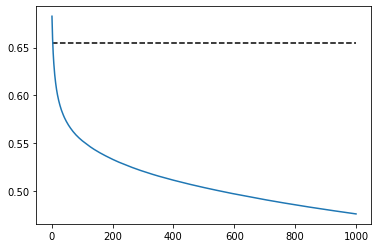

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

### Percentage of same class neighbors by angular section

In [51]:
distance_list = np.linspace(0.99, 0.5, 50)
distance_list

array([0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89,
       0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79, 0.78,
       0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68, 0.67,
       0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57, 0.56,
       0.55, 0.54, 0.53, 0.52, 0.51, 0.5 ])

In [52]:
perc_section_same_class = np.zeros(distance_list.shape)
n_section_neighbors = np.zeros(distance_list.shape)
n_section_same_class = np.zeros(distance_list.shape)
for idx, dist in enumerate(distance_list):
    n_section_neighbors[idx] = (distances > dist)[:, 1:].sum()
    n_section_same_class[idx] = (is_same_class * (distances > dist)[:, 1:]).sum()
    perc_section_same_class[idx] = n_section_same_class[idx] / n_section_neighbors[idx]
perc_section_same_class

array([0.66631612, 0.71789826, 0.72872956, 0.72776234, 0.72216701,
       0.71571554, 0.70981706, 0.70389174, 0.69845125, 0.69344801,
       0.68846   , 0.68371873, 0.67924723, 0.67510075, 0.67125473,
       0.66749335, 0.66341619, 0.65878686, 0.65363474, 0.64813198,
       0.64214203, 0.63587471, 0.62948022, 0.6232296 , 0.61706559,
       0.61101347, 0.6051485 , 0.59944343, 0.59381698, 0.58829063,
       0.58282463, 0.577425  , 0.57202785, 0.56666264, 0.56127536,
       0.5558604 , 0.55041261, 0.54495552, 0.53945696, 0.53397184,
       0.52852335, 0.52314077, 0.51783676, 0.51266604, 0.5076768 ,
       0.50289765, 0.49837888, 0.49418908, 0.49036579, 0.48698128])

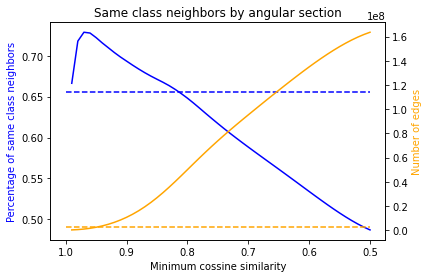

In [53]:
fig, ax1 = plt.subplots()
ax1.set_title('Same class neighbors by angular section')
ax1.set_ylabel('Percentage of same class neighbors', color='blue')
ax1.set_xlabel('Minimum cossine similarity')
ax1.invert_xaxis()
ax1.plot(distance_list, perc_section_same_class, color='blue')
ax1.hlines(0.6551, 1, 0.5, color='blue', ls='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of edges', color='orange')
ax2.plot(distance_list, n_section_neighbors, color='orange')
ax2.hlines(graph.edges()[0].shape[0], 1, 0.5, color='orange', ls='--')

#### Evaluating a single threshold

In [54]:
thresh = 0.8

Number of isolated nodes

In [55]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 0).sum()

413

Number of connected nodes

In [56]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 1).sum()

168930

Number of edges

In [57]:
((distances > thresh)[:, 1:] * 1).sum()

49955247

Number of edges in the graph - Undirected

In [58]:
graph.edges()[0].shape[0]

2332486

Degree distribution

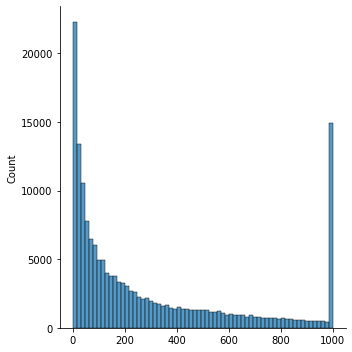

In [59]:
degree_dist = ((distances > thresh)[:, 1:] * 1).sum(axis=1)
sns.displot(degree_dist)

## Inner Product

In [60]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [61]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [62]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fe00171bb70> >

In [63]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [64]:
distances, indices = index_ip.search(embeddings, 2)

In [65]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(5860)

In [66]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [67]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

7.6122083194350125

In [68]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [69]:
indices

array([[162023, 107601,  48252, ..., 116266, 154791, 164723],
       [ 87529, 128446, 159095, ...,  25143,   7492, 165606],
       [ 76500, 108557, 148636, ...,  98719,  47870, 158194],
       ...,
       [162023,  29393,  48252, ...,  79193,  31012,   4337],
       [107601, 162023,  35094, ..., 131746,  58392, 123609],
       [129290, 137497,  40164, ..., 121789,  79635, 140260]])

In [70]:
sum(embeddings[0] * embeddings[411])

14.224416638870025

In [71]:
distances

array([[69.901886, 67.69512 , 50.643   , ..., 21.389313, 21.343397,
        21.330854],
       [49.55604 , 45.45586 , 42.0106  , ..., 30.59969 , 30.5909  ,
        30.560574],
       [30.672531, 28.897898, 28.860306, ..., 23.674683, 23.594652,
        23.586218],
       ...,
       [90.158875, 56.757446, 49.070892, ..., 22.582094, 22.58193 ,
        22.573534],
       [49.070686, 48.086212, 29.268124, ..., 14.146447, 14.143709,
        14.12765 ],
       [52.91218 , 48.77464 , 46.567783, ..., 33.46774 , 33.45056 ,
        33.421272]], dtype=float32)

In [72]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [73]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

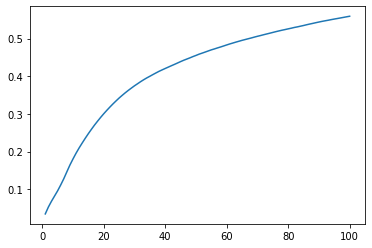

In [74]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [75]:
percentages

tensor([0.0346, 0.0528, 0.0681, 0.0819, 0.0958, 0.1112, 0.1278, 0.1461, 0.1642,
        0.1804, 0.1956, 0.2097, 0.2228, 0.2354, 0.2476, 0.2592, 0.2704, 0.2807,
        0.2908, 0.3004, 0.3095, 0.3182, 0.3265, 0.3345, 0.3422, 0.3493, 0.3561,
        0.3626, 0.3686, 0.3746, 0.3801, 0.3856, 0.3908, 0.3956, 0.4000, 0.4045,
        0.4089, 0.4132, 0.4170, 0.4207, 0.4243, 0.4280, 0.4315, 0.4352, 0.4389,
        0.4424, 0.4456, 0.4488, 0.4522, 0.4553, 0.4586, 0.4614, 0.4643, 0.4672,
        0.4701, 0.4726, 0.4752, 0.4778, 0.4804, 0.4832, 0.4858, 0.4882, 0.4907,
        0.4930, 0.4954, 0.4975, 0.4996, 0.5017, 0.5040, 0.5061, 0.5081, 0.5103,
        0.5123, 0.5143, 0.5164, 0.5185, 0.5204, 0.5223, 0.5240, 0.5259, 0.5276,
        0.5296, 0.5311, 0.5330, 0.5348, 0.5368, 0.5386, 0.5404, 0.5422, 0.5440,
        0.5457, 0.5473, 0.5487, 0.5504, 0.5519, 0.5533, 0.5548, 0.5563, 0.5579,
        0.5594])

### Percentage of same class neighbors by neighborhood size

In [76]:
ind_labels = label_transform(indices)

In [77]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [78]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [79]:
perc_same_class = n_same_class / n_total

In [80]:
perc_same_class

array([0.21951896, 0.21056081, 0.20398048, 0.2003921 , 0.19831466,
       0.19715705, 0.19681357, 0.19709185, 0.19768294, 0.19840501,
       0.19913591, 0.19999449, 0.20062331, 0.20126818, 0.20181131,
       0.20221865, 0.2024735 , 0.20266297, 0.2028182 , 0.20286873,
       0.20290996, 0.2028704 , 0.20277189, 0.2026282 , 0.20244545,
       0.20227631, 0.20205146, 0.20183107, 0.20157965, 0.20129008,
       0.20100681, 0.20069308, 0.20035578, 0.20002511, 0.19967943,
       0.1993377 , 0.19903727, 0.19872964, 0.19841538, 0.19811581,
       0.19779066, 0.19748479, 0.19716815, 0.1968698 , 0.1965687 ,
       0.19623923, 0.19593998, 0.19569011, 0.19541669, 0.19517488,
       0.19490527, 0.19468759, 0.19444325, 0.19420665, 0.19394816,
       0.19373539, 0.19350398, 0.19328187, 0.19306278, 0.19286901,
       0.19267617, 0.19246774, 0.19228974, 0.19210834, 0.19192218,
       0.19175981, 0.19158661, 0.19141546, 0.19125423, 0.19109491,
       0.19093992, 0.19078816, 0.19062357, 0.19044923, 0.19028

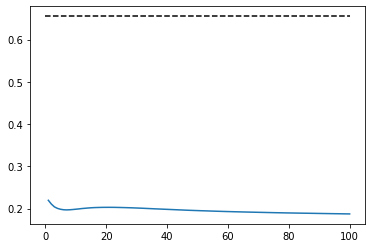

In [81]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [82]:
pca = PCA(n_components=2)

In [83]:
pca.fit(embeddings)

PCA(n_components=2)

In [84]:
emb_2d = pca.transform(embeddings)

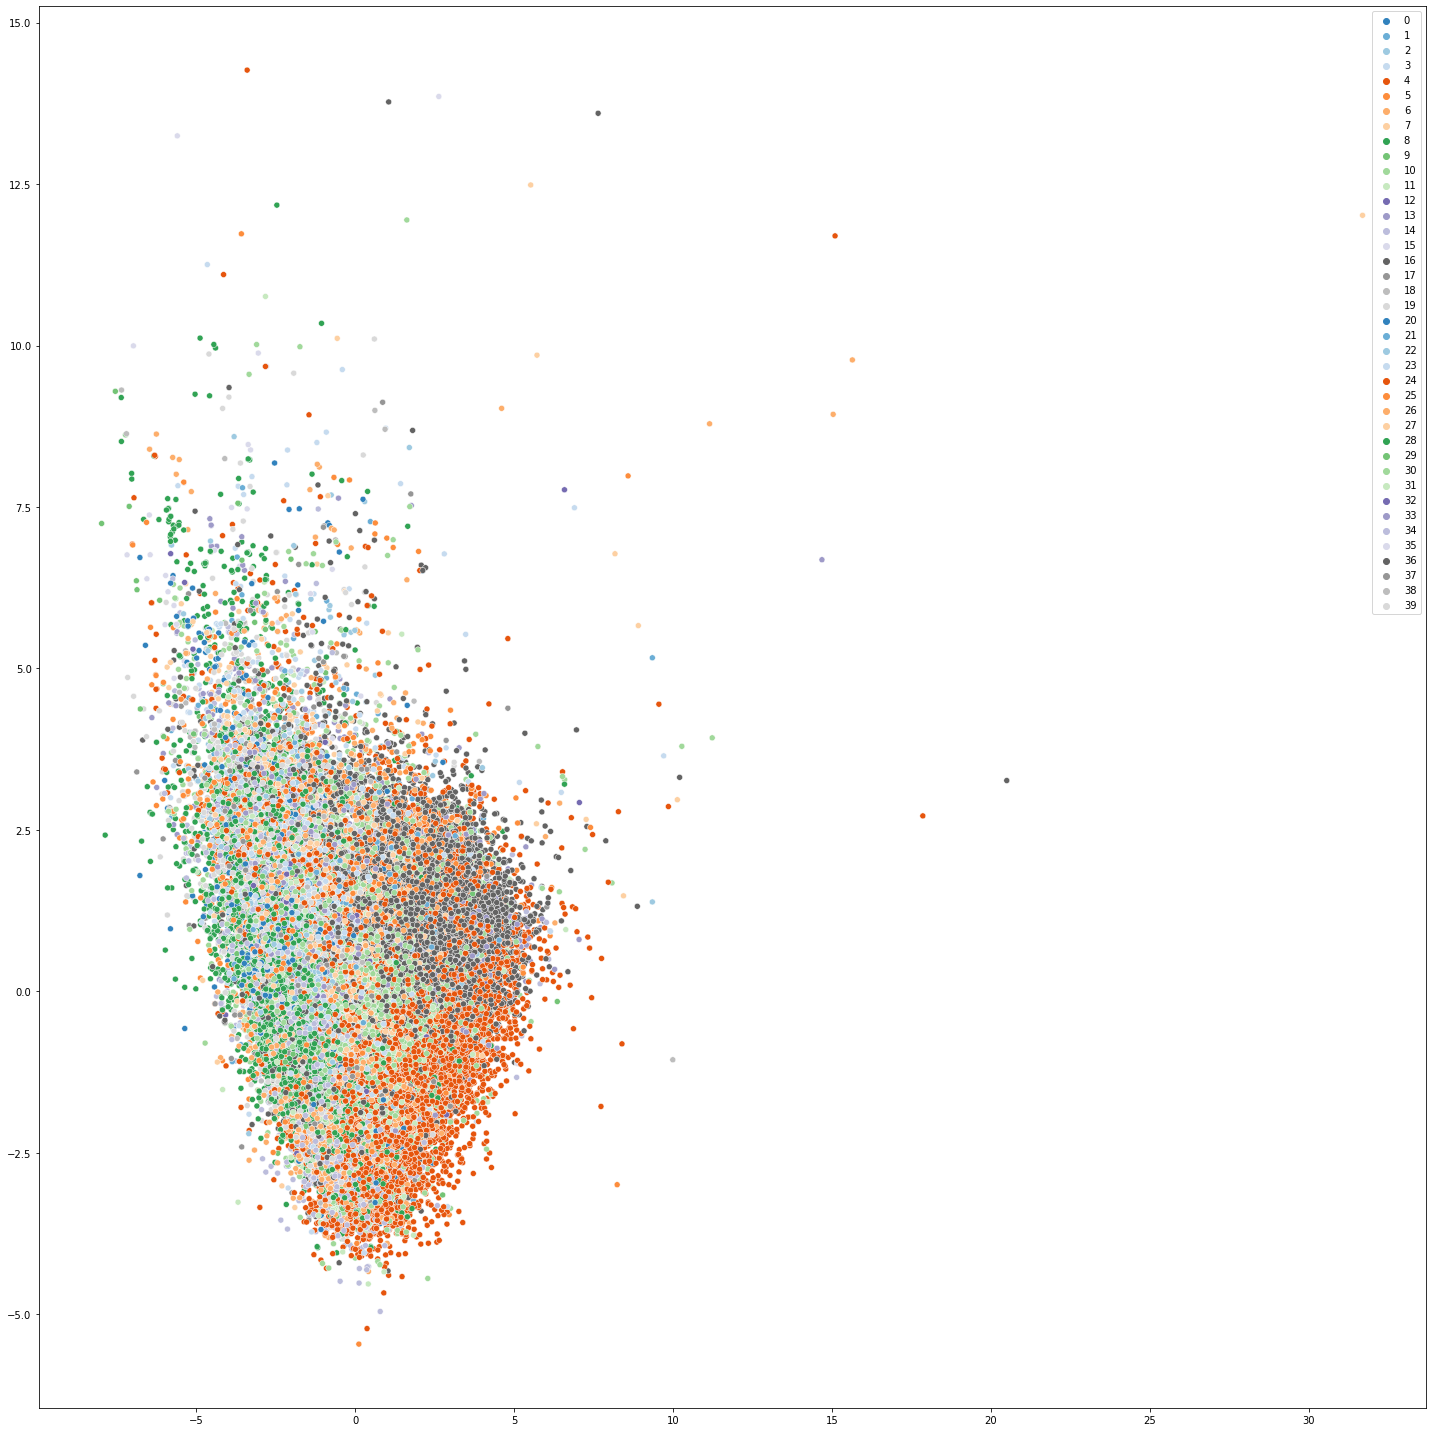

In [85]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [86]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

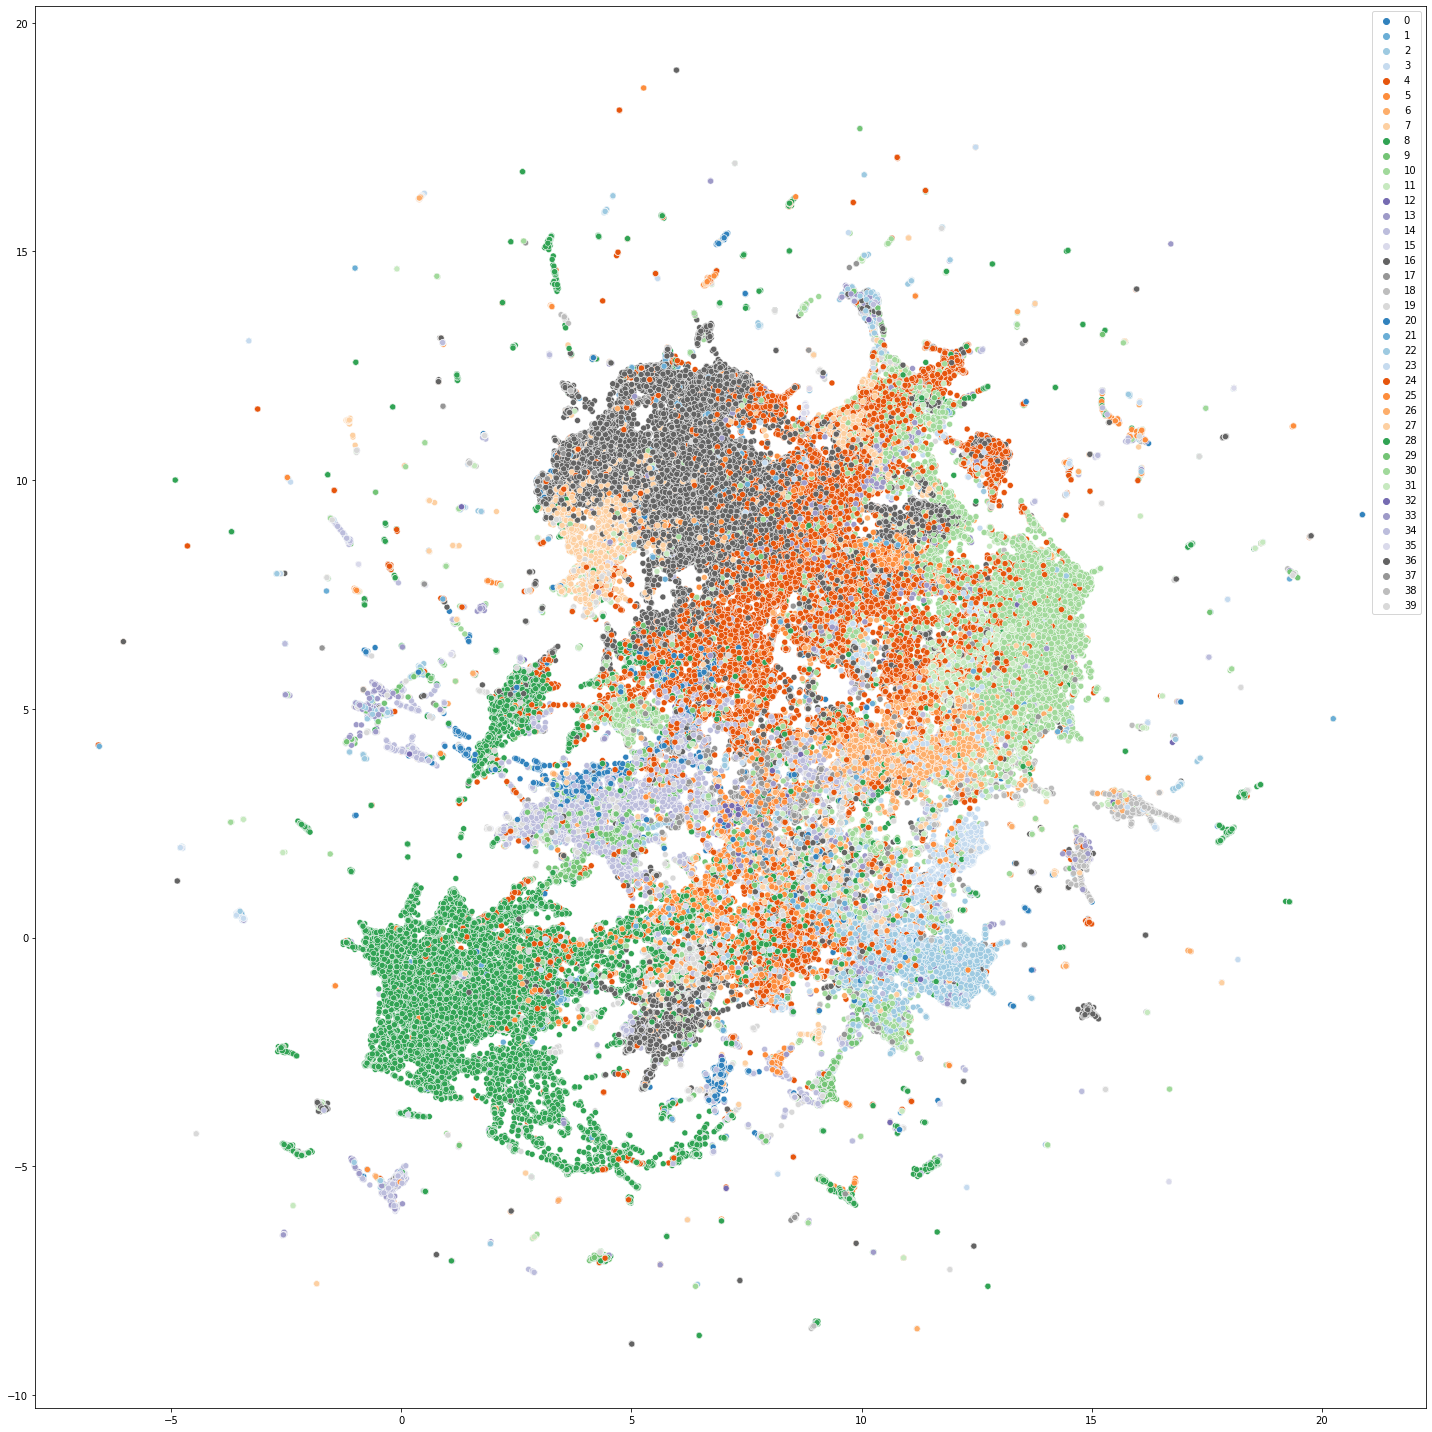

In [87]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [88]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

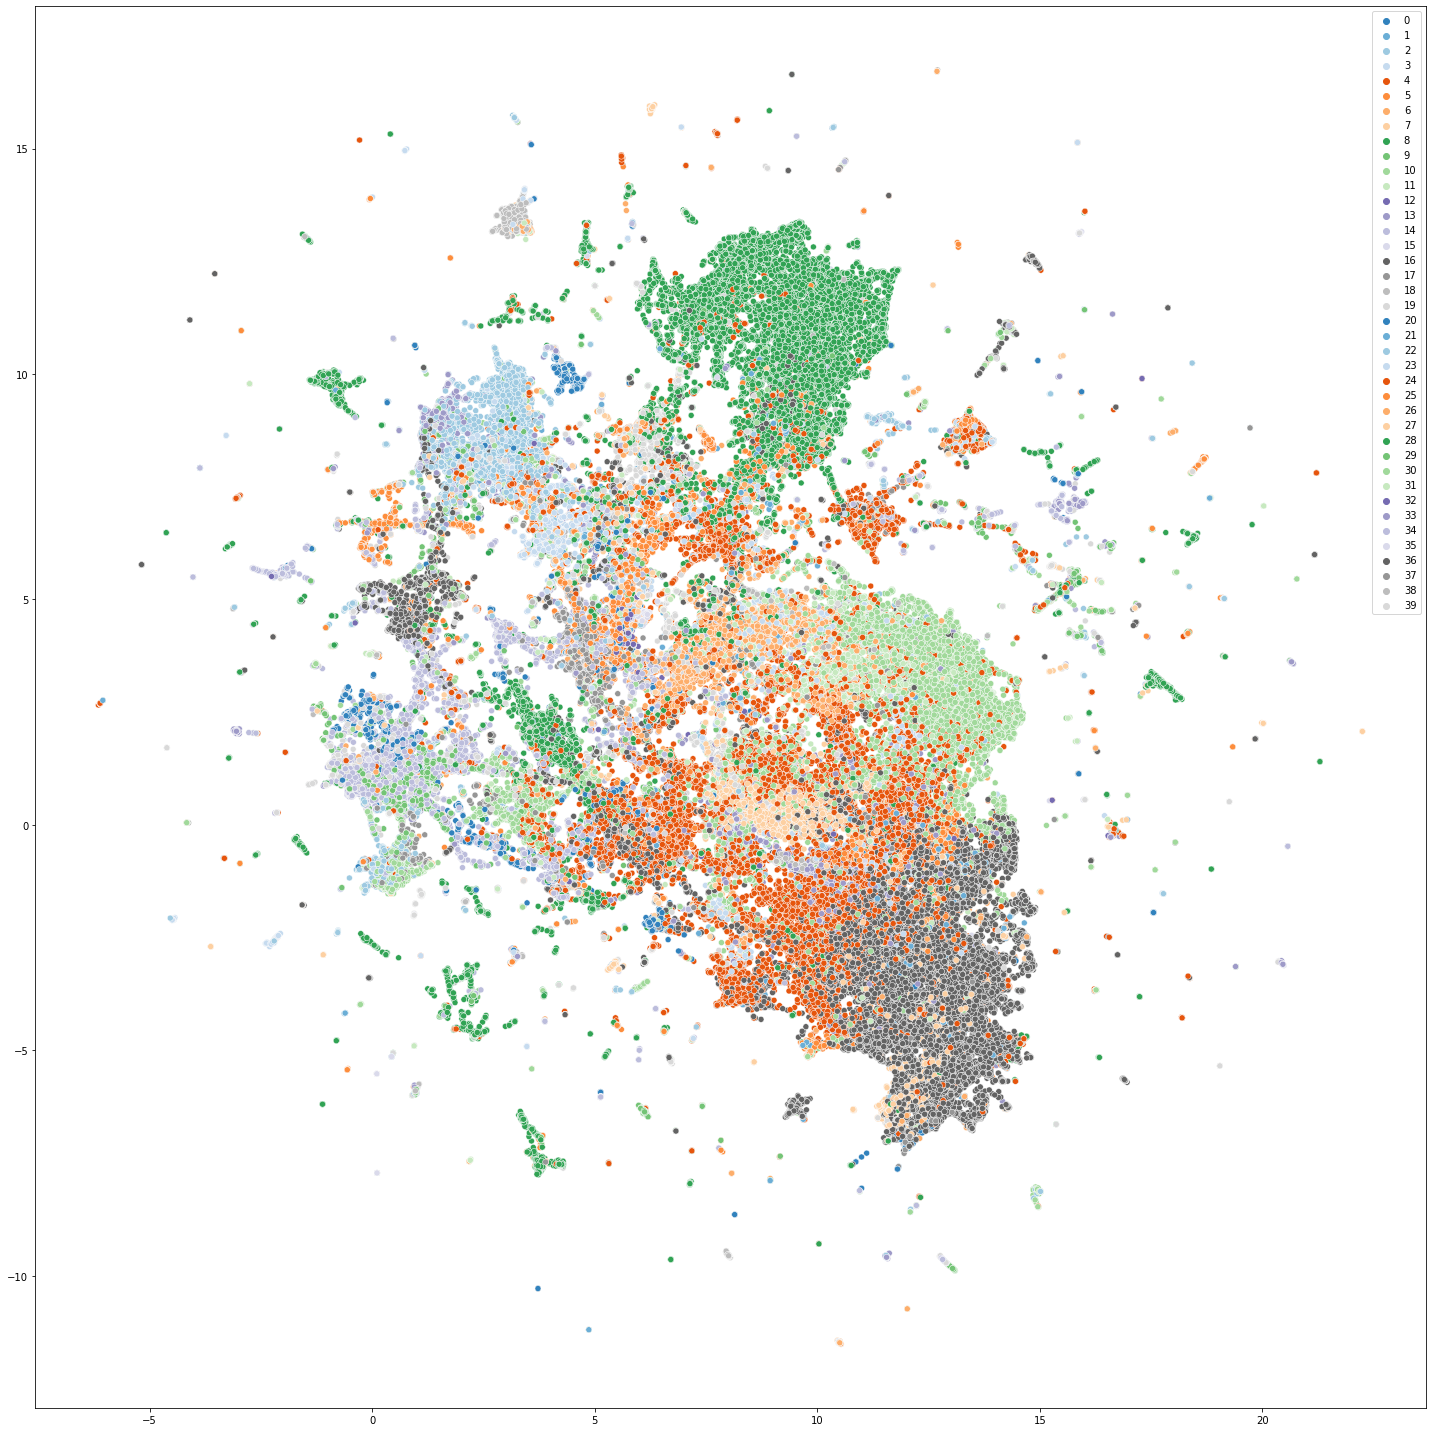

In [89]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()